In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# import classical libraries
%matplotlib inline
%pylab inline

# figure size
plt.rcParams['figure.figsize'] = (16, 9)

In [0]:
# import functions
from os import listdir
from os.path import isfile, join
from imageio import imread

# paths to the training and validation datasets
path_train = "/content/drive/My Drive/Colab Notebooks/SAR/training/"
path_validation = "/content/drive/My Drive/Colab Notebooks/SAR/validation/"

Import the data and set traning/validation data

In [0]:
from tensorflow import keras

# class names
classes = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
classes_num = np.arange(10)

# initialization
X_train = []
y_train = []
X_validation = []
y_validation = []
dim=(450,450)

# loop on images
for j in range(len(classes)):
    path = path_train + classes[j]
    files = [f for f in listdir(path) if isfile(join(path, f))]
    
    # training
    for i in range(len(files)):
        tmp = imread(path + '/' + files[i])
        X_train.append(receize(tmp[0:450,0:450:,0:3],dim))
        y_train.append(classes_num[j])
    # validation
    path = path_validation + classes[j]
    files = [f for f in listdir(path) if isfile(join(path, f))]
    for i in range(len(files)):
        tmp = imread(path + '/' + files[i])
        X_validation.append(receize(tmp[0:450,0:450:,0:3],dim))
        y_validation.append(classes_num[j])
        
# transform to array
X_train = asarray(X_train)
y_train = asarray(y_train)
X_validation = asarray(X_validation)
y_validation = asarray(y_validation)

print(y_validation.shape)
print(X_validation.shape)
print(y_train.shape)
print(X_train.shape)

#Categorize in 10 classes
y_train=keras.utils.to_categorical(y_train,10)
y_validation=keras.utils.to_categorical(y_validation,10)

In [0]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, Flatten, BatchNormalization
from keras.applications import InceptionV3  
from keras import optimizers 

CLASSES = 10

# SETUP MODELS

inp=Input(shape=(12,12,2048))
flatten_layer = Flatten()  
x=BatchNormalization()(inp)
x = flatten_layer(x)
preds = Dense(CLASSES, activation='softmax')(x) #final layer with softmax activation
mlp  = Model(inputs=inp,outputs=preds)

base_model = InceptionV3(weights='imagenet', include_top=False)

inp2=Input(shape=(450,450,3))
x = base_model(inp2)
x = mlp(x)
model_all =Model(inputs=inp2,outputs=x)

# transfer learning
#for layer in base_model.layers:
#  layer.trainable = False



In [0]:
base_model.summary()
mlp.summary()
model_all.summary()

In [0]:
mlp.compile(loss="categorical_crossentropy", optimizer=optimizers.Adadelta(lr=1e-4),metrics=["accuracy"])
model_all.compile(loss="categorical_crossentropy", optimizer=optimizers.Adadelta(lr=1e-4),metrics=["accuracy"])

In [0]:
EPOCHS = 50
BATCH_SIZE = 20

history = model_all.fit(X_train,y_train,
    epochs=EPOCHS, 
    validation_data=(X_validation, y_validation))

In [0]:
#Calculate validation score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# compute the score 
score = model_all.evaluate(X_validation , y_validation, verbose=0)

# predict the X_validation
y_prediction = model_all.predict(X_validation)
y_prediction=np.argmax(y_prediction,axis=1)
y_prediction=keras.utils.to_categorical(y_prediction, 10)

# compute confusion matrix
ConfMat=confusion_matrix(np.argmax(y_validation,axis=1), np.argmax(y_prediction,axis=1))
print('The accuracy value = ',str(round(score[1],2)))
#print('The loss value = ',str(score[0]))

/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


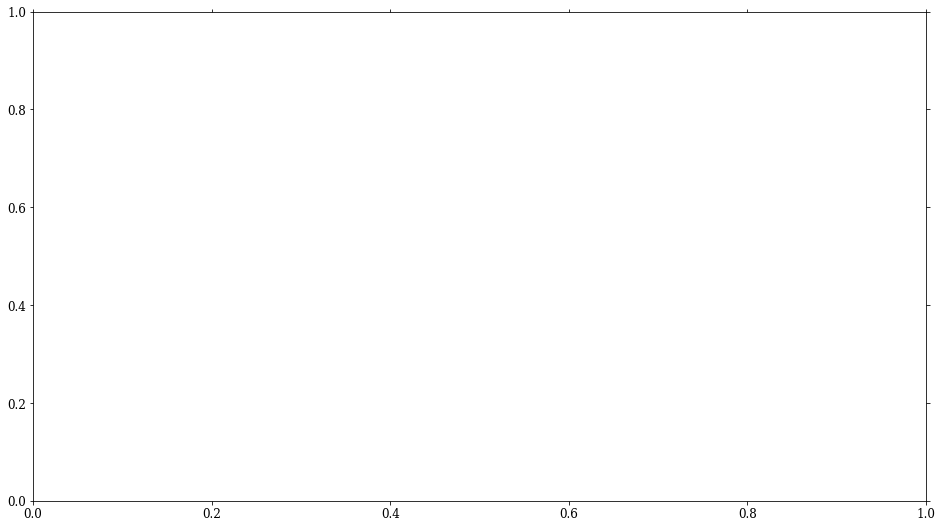

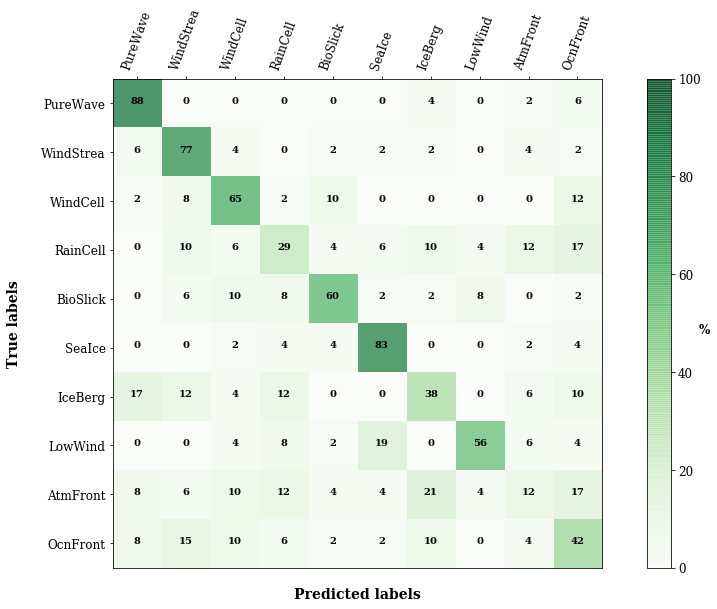

In [0]:
#Plot confusion matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools


# define some matplotlib parameters
plt.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams.update({'font.family': 'serif','text.latex.unicode':True,'axes.labelsize': 'large',
             'axes.labelweight':'bold',
             'axes.titlesize':'large',
             'axes.titleweight':'bold',
             'xtick.labelsize':12,
             'ytick.labelsize':12}) 

plt.tick_params(top='on',bottom='off',left='on',right='off')
plt.rc('font', family='serif')
# classes names 
Names=['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
# classes true names 
TrueNames=['PureWave', 'WindStrea', 'WindCell', 'RainCell', 'BioSlick', 'SeaIce', 'IceBerg', 'LowWind', 'AtmFront' ,'OcnFront']
AllClasses=np.arange(10)
dic=dict(zip(Names,TrueNames))

ConfMat = ConfMat.astype('float') / ConfMat.sum(axis=1)[:, np.newaxis]*100
#print("Normalized confusion matrix")
Max=100
Name="ConfMatNormalized"
unit=r'%'
#print(ConfMat)
fig, ax = plt.subplots()
cax = ax.matshow(ConfMat, vmin=0, vmax=Max,cmap='Greens',alpha=0.7)
cbar=fig.colorbar(cax)
cbar.ax.set_ylabel(str(unit), rotation=0)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, [dic[x] for x in Names],rotation=70)
plt.yticks(tick_marks, [dic[x] for x in Names])
ax.tick_params(top='True', bottom='False')
fmt = '.0f'
thresh = ConfMat.max() / 2.
for i, j in itertools.product(range(ConfMat.shape[0]), range(ConfMat.shape[1])):
    plt.text(j, i, format(ConfMat[i, j], fmt),
              horizontalalignment="center",weight="bold",
              color= "black")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('top')
plt.ylabel('True labels',fontweight='bold',fontsize=14,labelpad=20)
plt.xlabel('Predicted labels',fontweight='bold',fontsize=14,labelpad=20)
plt.show()

# save confusion matrix to drive
#plt.savefig("/content/drive/My Drive/ConfMat.jpg", bbox_inches='tight',dpi=300)
#plt.close()